# Novelty Function and Onset Detection

This notebook introduces onset detection using novelty functions, with hands-on Python examples and visualizations.

- **Section 0 - Pre-requisites**

  Setting up the environment with the required Python libraries.

- **Section 1 - Novelty Function**

  Introduce and implement three complementary novelty functions: Time-Domain, STFT-Based, and Pitch-Domain
- **Section 2 - Onset Detection**

  Apply the novelty functions to detect onsets. Visualized the result with a naive tick example and a real dataset example.


- **Section 3 - Evaluation Metrics**
  
  Assess detection quality using Precision, Recall, F-Measure within a timing tolerance, and report timing quality with mean absolute deviation, standard deviation, and max deviation for matched events.

# 0. Pre-requisites: setting up the environment

In [ ]:
# install the pyACA library
!pip install pyACA

# When not using jupyter environment, please remember install below dependencies:
# !pip install numpy
# !pip install scipy

# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# 1. Novelty function


---

## References
Text book: [Sect. 9.3.1](https://ieeexplore.ieee.org/document/9966202/)

Slides: [09-03-ACA-Temporal-Onsets.pdf](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/09-03-ACA-Temporal-Onsets.pdf)

## Summary:
A Novelty Function measures the probability of new events or signal changes occurring over `time`. Also known as a detection function or difference function, it can be categorized into three domains: `time domain`, `pitch domain`, and `STFT-based`. It is often used in the Onset detection tasks.


## How it usually works:
(For a detailed implementation of these steps, we can examine the [`computeNoveltyFunction`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/computeNoveltyFunction.py#L32) source code)
1. Feature extraction
2. Deveriation computation
3. Result Smoothing
4. Half-Wave-Rectification
Finally, we can attempt to find local maxima above the threshold for tasks such as onset, beat detection.





## 1.1 Time Domain Novelty Function:
A time-domain novelty function here works by framing the audio, computing short-time energy per frame, then taking a first difference so rising energy becomes spikes. The result is smoothed to reduce jitter and half-wave rectified to keep only upward attacks. An adaptive threshold (a longer moving average plus a small offset) tracks the local baseline, and onsets are taken as peaks where the novelty rises above this threshold.

### When to choose Time Domain Novelty Function:

- Clear transients / percussive material: drums or note attacks with sharp amplitude rises.

- Clean or moderately mixed signals like low noise.

- Low-cost/real-time needs: it’s lightweight (no STFT), great for embedded or live onset triggers.

- Coarse onset timing is enough: you just need “when something starts,” not timbral detail.



In [2]:
# an example of time domain novelty function:
import numpy as np
import math
from scipy.signal import filtfilt
from scipy.signal import find_peaks

def computeEnergyNovelty(wav, frame_size, hop_size, f_s):
    # Calculate the number of frames
    num_frames = 1 + (len(wav) - frame_size) // hop_size
    energy = np.zeros(num_frames)
    t = np.arange(0, len(wav) / f_s, hop_size / f_s)[:num_frames]
    # Compute energy for each frame
    for i in range(num_frames):
        start = i * hop_size
        frame = wav[start:start+frame_size]
        energy[i] = np.sum(frame ** 2)

    # Compute novelty function as the positive difference between adjacent energy values
    d = np.diff(energy, prepend=energy[0])

    fLenSmoothLpInS = 0.07
    fLenThreshLpInS = 0.14
    iLenSmoothLp = np.max([2, math.ceil(fLenSmoothLpInS * f_s / hop_size)])
    iLenThreshLp = np.max([2, math.ceil(fLenThreshLpInS * f_s / hop_size)])

    b = np.ones(iLenSmoothLp) / iLenSmoothLp
    d = filtfilt(b, 1, d)
    d[d < 0] = 0

    # compute threshold
    iLenThreshLp = min(iLenThreshLp, np.floor(len(d)/3))
    b = np.ones(iLenThreshLp) / iLenThreshLp
    G_T = .4 * np.mean(d[np.arange(1, d.shape[0])]) + filtfilt(b, 1, d)

    # find local maxima above the threshold
    iPeaks = find_peaks(d - G_T, height=0)

    return d, t, iPeaks[0]

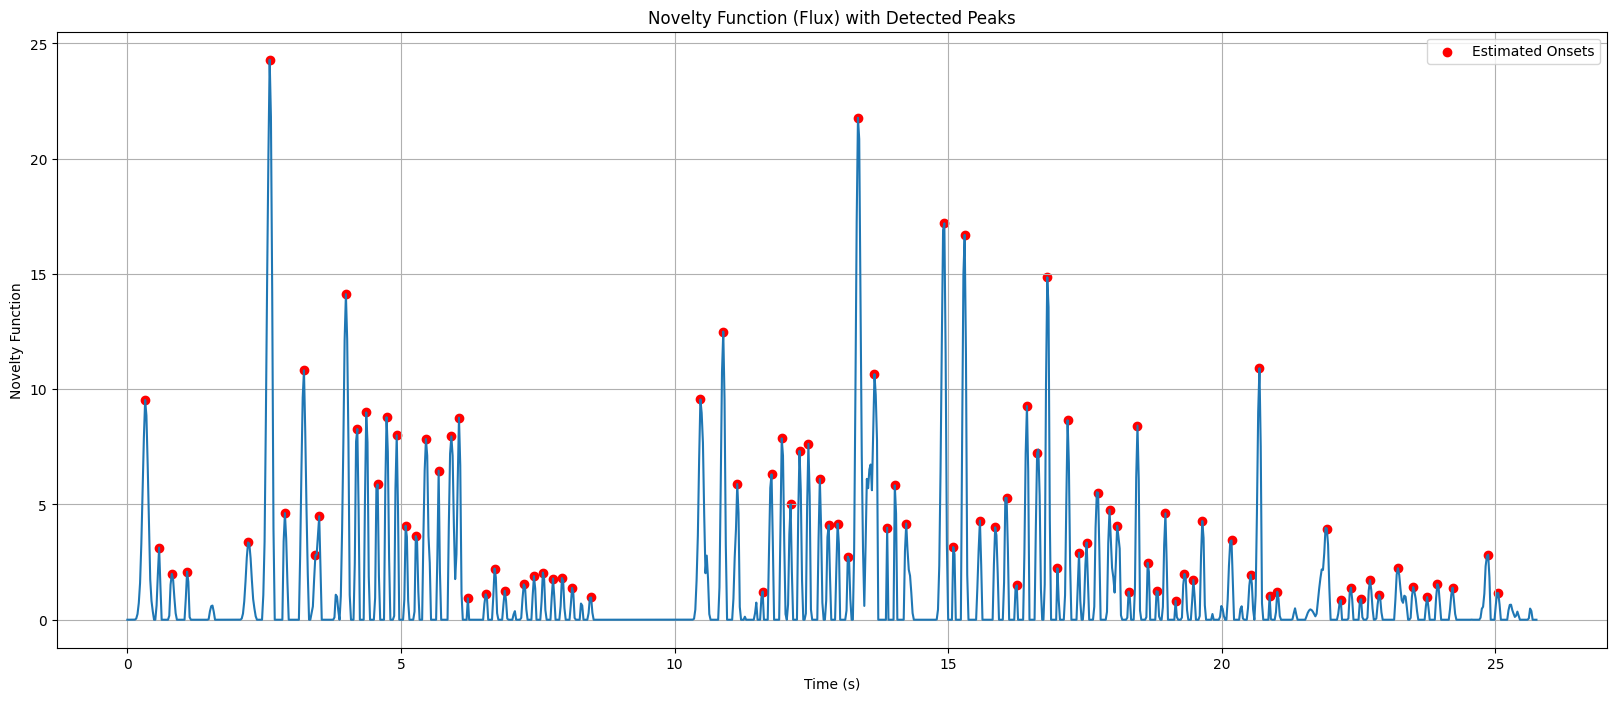

In [4]:
from utils.visualize import visualizeNoveltyFunction
from pyACA import ToolReadAudio

# Read audio
f_s, wav = ToolReadAudio('Audio_Asset/02-Novelty_Onset/01-D_AMairena.wav')
d, t, iPeaks = computeEnergyNovelty(wav, frame_size=2048, hop_size=1024, f_s=f_s)
visualizeNoveltyFunction(d, t, iPeaks)


## 1.2. STFT-based Novelty Function:
STFT-based novelty measures frame-to-frame spectral change rather than raw amplitude change. We compute a spectrogram by STFT, then compare adjacent magnitude spectra to highlight moments where the frequency distribution shifts—typical at note attacks and timbral changes.

### When to choose STFT-based Novelty Function:
- Polyphonic / dense mixes where amplitude envelopes are misleading but timbre changes are clear.
- Sustained instruments with soft attacks (strings, pads, vocals) where spectral shape shifts more than energy.
- Noisy or live recordings: spectral differencing often rejects steady noise better than time-domain energy.

Here, supported novelty function for `STFT-based` in PyACA are:
-    [`NoveltyFlux`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyFlux.py)
-    [`NoveltyHainsworth`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyHainsworth.py)
-    [`NoveltyLaroche`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyLaroche.py)

Here is an example:

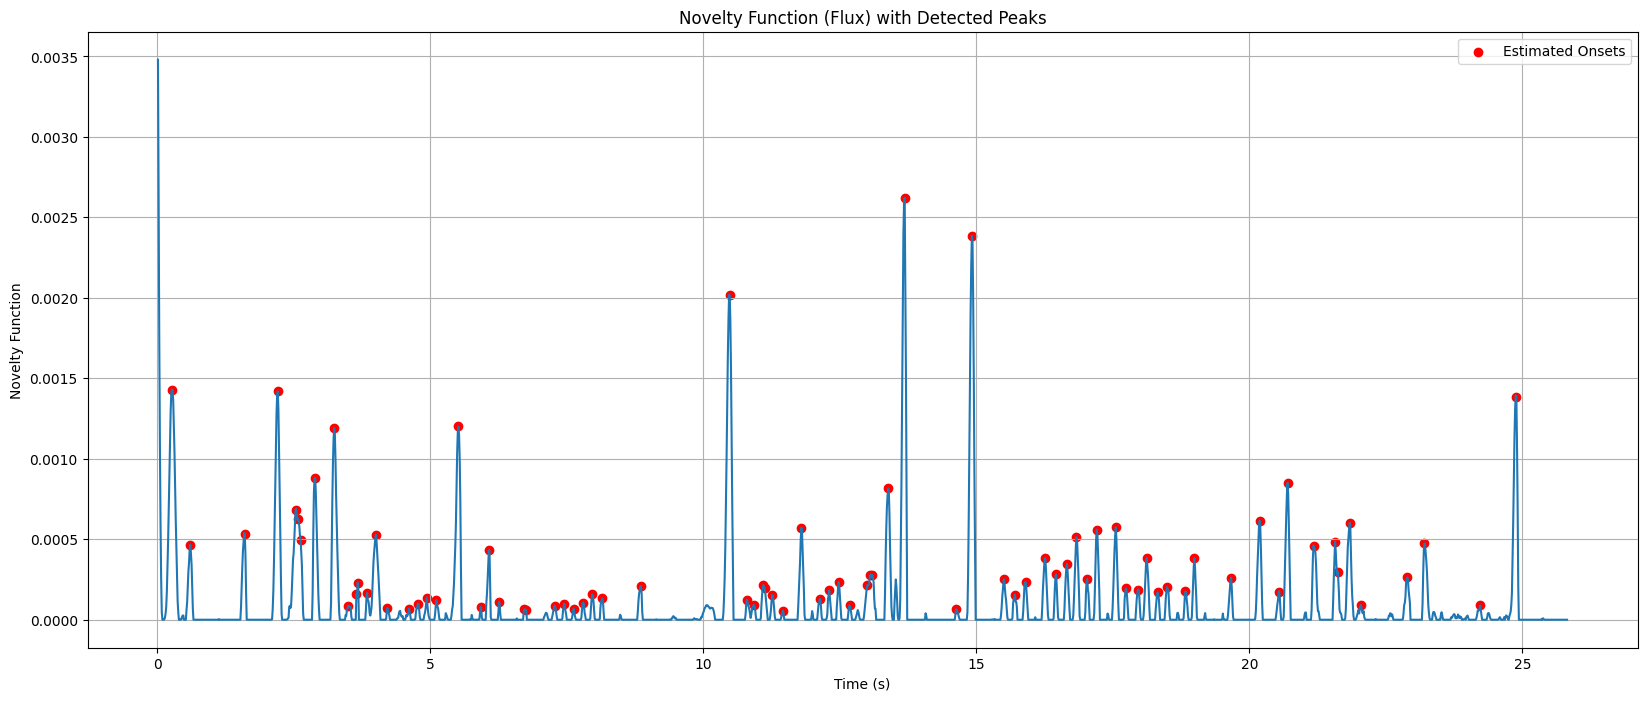

In [5]:
from pyACA import computeNoveltyFunction
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA.ToolComputeHann import ToolComputeHann
from utils.visualize import visualizeNoveltyFunction
from pyACA import ToolReadAudio

# Settings
iBlockLength = 1024
iHopLength = 512
novelty_func = 'Laroche' # can be 'Hainsworth', 'Laroche'
# Read audio
f_s, wav = ToolReadAudio('Audio_Asset/02-Novelty_Onset/01-D_AMairena.wav')
# Compute Hann window
afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)
# Visualize novelty function
visualizeNoveltyFunction(d, t, peaks)




## 1.3. Pitch Domain Novelty Function:

Pitch-domain novelty tracks changes in fundamental frequency (F0) over time. After estimating a pitch contour, take a first difference of the contour, smooth it, half-wave rectify, and threshold to highlight pitch jumps, note starts, bends, and glides that may not create large energy or broadband spectral changes.

### When to choose Pitch Domain Novelty Function:
- Monophonic or lightly polyphonic melodies (solo voice, bass lines, lead instruments) where the onset is marked by a pitch transition rather than a big energy rise.

- Expressive playing with glides, vibrato, or bends (strings, vocals, winds) where pitch motion signals event boundaries.

Here, we can simply take the pitch estimation function that used in `PitchContour.ipynb` to compute pitch domain novelty function:

In [6]:
# An example of pitch domain novelty function:
import pyACA

def computePitchNovelty(wav, frame_size, hop_size, f_s):
    pitchAlgo = 'TimeAcf'
    est_freq, t = pyACA.computePitch(pitchAlgo, wav, f_s, iBlockLength=frame_size, iHopLength=hop_size)
    d = np.diff(est_freq, prepend=est_freq[0])

    fLenSmoothLpInS = 0.1
    fLenThreshLpInS = 0.14
    iLenSmoothLp = np.max([2, math.ceil(fLenSmoothLpInS * f_s / hop_size)])
    iLenThreshLp = np.max([2, math.ceil(fLenThreshLpInS * f_s / hop_size)])

    b = np.ones(iLenSmoothLp) / iLenSmoothLp
    d = filtfilt(b, 1, d)
    d[d < 0] = 0

    # compute threshold
    iLenThreshLp = min(iLenThreshLp, np.floor(len(d)/3))
    b = np.ones(iLenThreshLp) / iLenThreshLp
    G_T = .6 * np.mean(d[np.arange(1, d.shape[0])]) + filtfilt(b, 1, d)

    # find local maxima above the threshold
    iPeaks = find_peaks(d - G_T, height=0)

    return d, t, iPeaks[0]

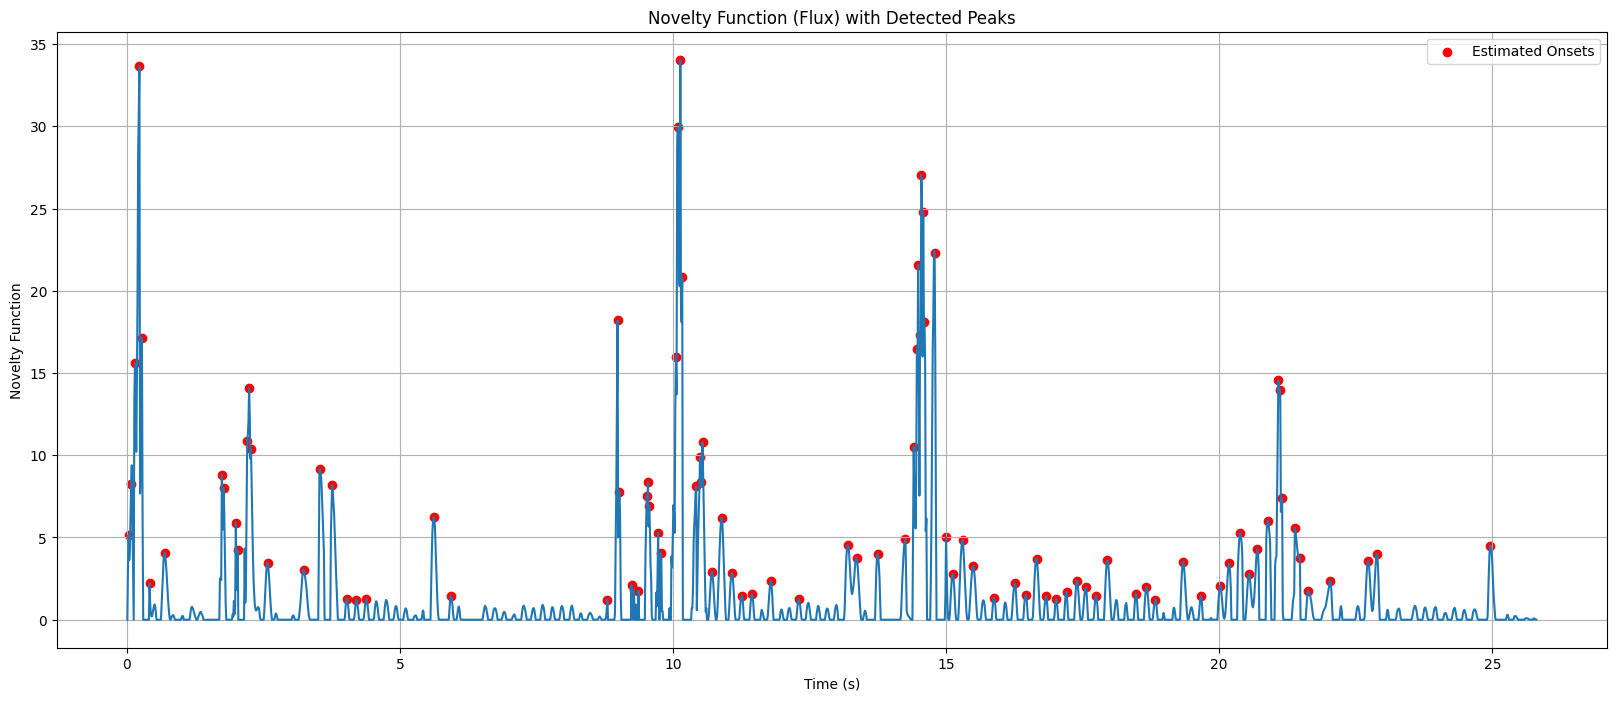

In [9]:

from pyACA import ToolReadAudio

f_s, wav = ToolReadAudio('Audio_Asset/02-Novelty_Onset/01-D_AMairena.wav')
# ignore the very last novelty sample
valid_len = (len(wav) - iBlockLength)
wav = wav[:valid_len]
d, t = d[:-1], t[:-1]
d, t, iPeaks = computePitchNovelty(wav, 1024, 512, f_s)
visualizeNoveltyFunction(d, t, iPeaks)

# 2. Onset Detection
---
## References
Text book: [Sect. 9.3](https://ieeexplore.ieee.org/document/9966202/)

Slides: [09-03-ACA-Temporal-Onsets.pdf](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/09-03-ACA-Temporal-Onsets.pdf)

## Summary:
The goal of onset detection is to segment the audio stream into separate musical events. This supports tasks such as tempo detection or automatic music transcription and enables the analysis of rhythm and timing.


## How it usually works:
1. Novelty Function computation
2. Peak picking

That is, we can just simply use novelty function above and pick proper peaks for the onset detection. For exanple, We can generate a rhythmic ticking sound, compute its novelty function, and then pick the peak of its novelty function. See the code below:

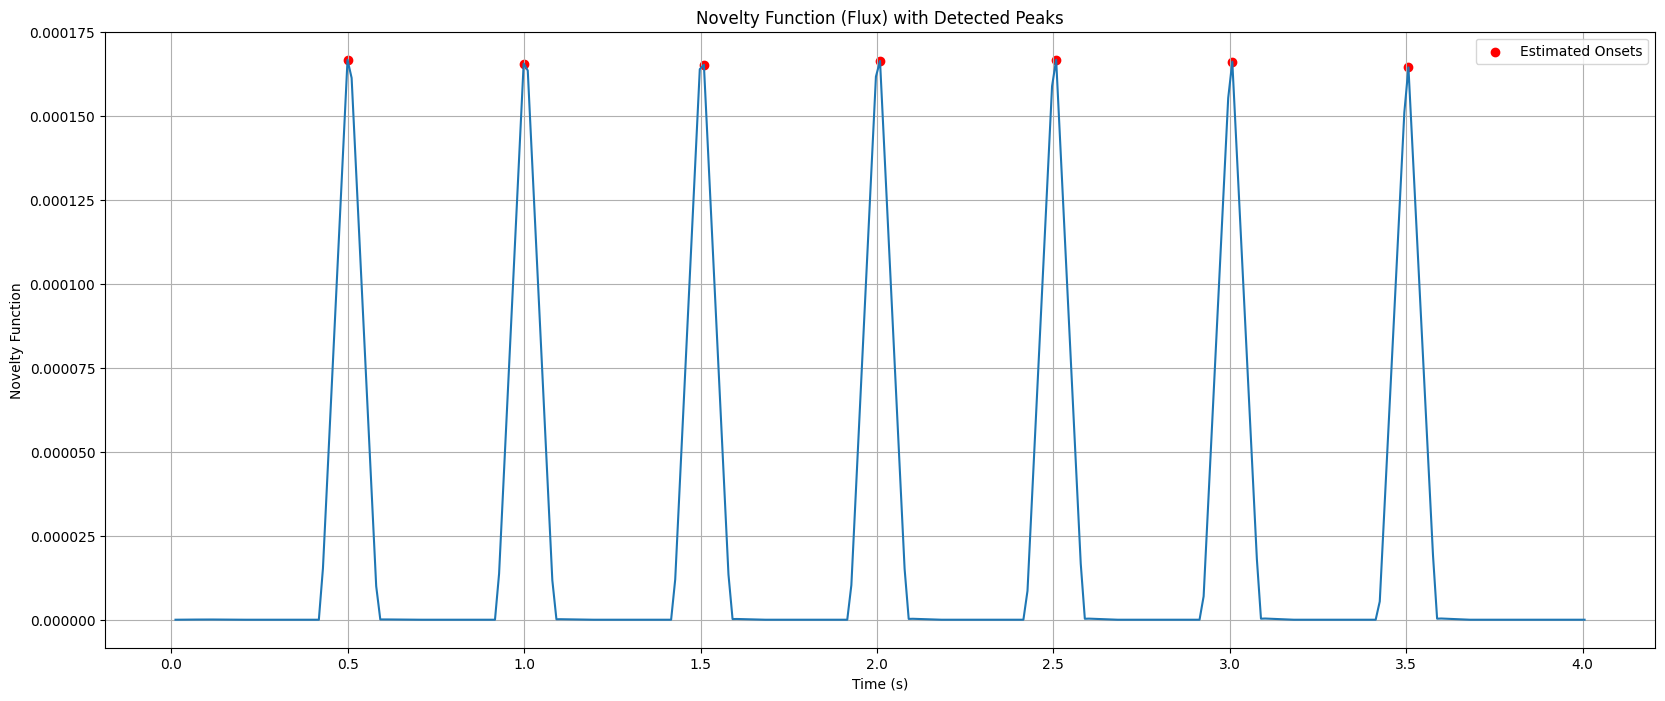

In [ ]:
from utils.base import tickGen
from utils.visualize import visualizeNoveltyFunction
import matplotlib.pyplot as plt
from pyACA.ToolComputeHann import ToolComputeHann
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA import computeNoveltyFunction

# Configure parameters
iBlockLength = 1024
iHopLength = 512
novelty_func = 'Flux' # can be 'Hainsworth', 'Laroche'

# Generate ticking sound
f_s, wav = tickGen(bpm=120, sample_rate=44100)
afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)
visualizeNoveltyFunction(d, t, peaks)





Now, try apply onset detection on audio data from MDB Drums dataset:

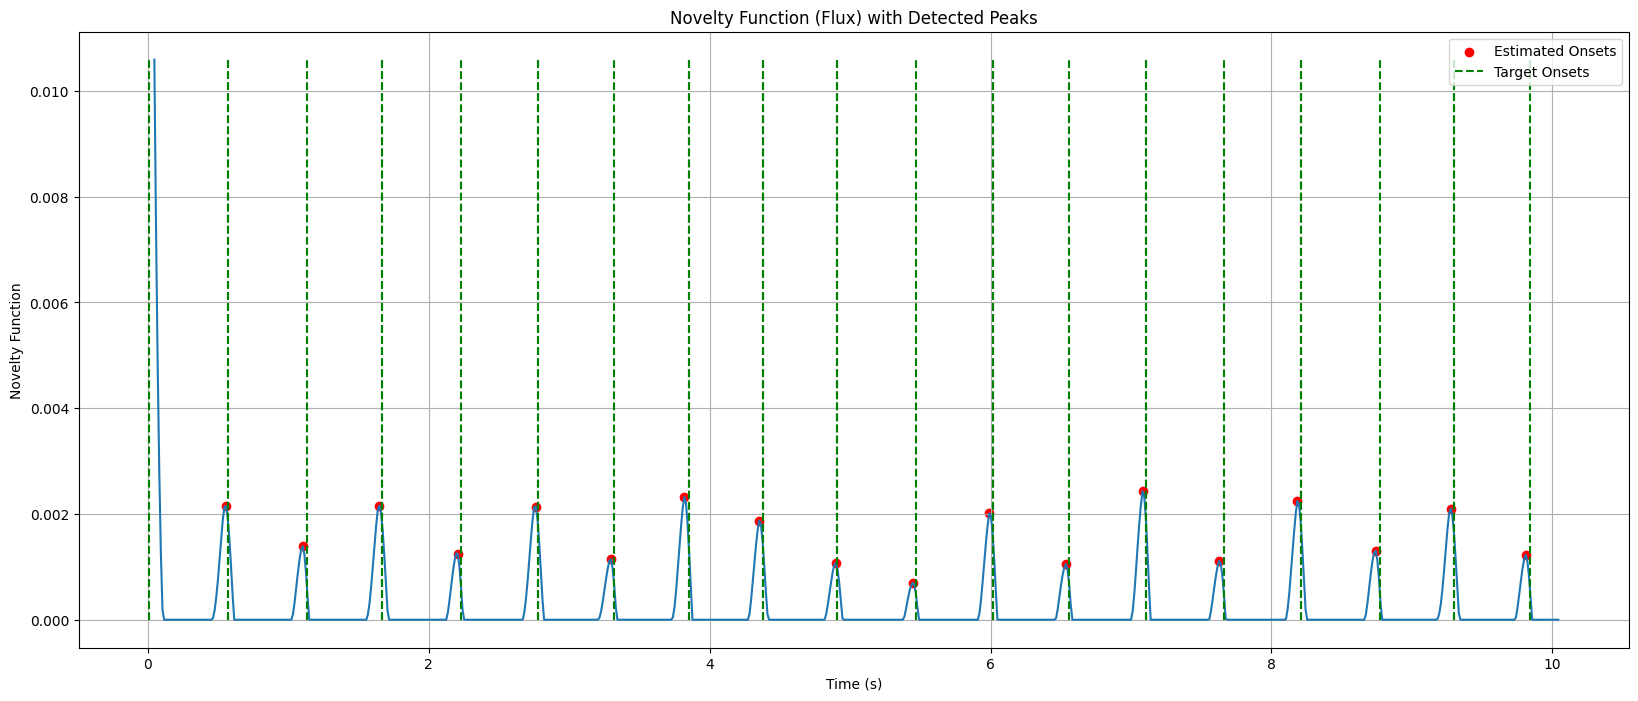

In [ ]:
import numpy as np
from pyACA import ToolReadAudio
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA.ToolComputeHann import ToolComputeHann
from pyACA import computeNoveltyFunction
from utils.visualize import visualizeNoveltyFunction

f_s, wav = ToolReadAudio('Audio_Asset/02-Novelty_Onset/02-MusicDelta_80sRock_Drum.wav')
# load first 10 seconds
wav = wav[:int(10.0 * f_s)]

iBlockLength = 4096
iHopLength = 512
novelty_func = 'Laroche' # can be 'Flux', 'Hainsworth', 'Laroche'

afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)


# load target onsets
ref_onsets = np.loadtxt('Audio_Asset/02-Novelty_Onset/02-MusicDelta_80sRock_class.txt', delimiter=',')
visualizeNoveltyFunction(d, t, peaks, target=ref_onsets)



# 3. Evaluation Metrics
---
### Reference

Text book: [Sect. 9.3.3](https://ieeexplore.ieee.org/document/9966202/)

### Summary

We take esitmated onset times to compare with the reference onset times as given by the ground truth.
Predicted onsets within a tolerance interval around each ground truth interval are considered as correct, while others are incorrect. Typical tolerance intervals range from $\pm 25$ ms to $\pm 50$ ms.

### How it usually works:

#### 1. Precision, Recall, F-Measure

- Precision: measure "How many of the detected onsets were correct?"
- Recall: measure “How many true onsets did we find?”
- F-Measure: score balancing precision and recall


In [ ]:
import utils.eval as eval
est_onset = t[peaks]
f_measure, precision, recall = eval.computeTemporalFmeasure(est_onset, ref_onsets)
print(f"F-Measure: {f_measure:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

F-Measure: 0.47, Precision: 1.00, Recall: 0.31


#### 2. Deviation statistics

Given $ \Delta t_o(j) = t_o(j) − \hat{t_o}(j) $
Some other metric could be:
1. Mean deviation: $$d_{mean} = \sum_{\forall j} \Delta t_o(j) $$
It reflects typical timing error of predication and reference. Lower is better.
2. Standard deviation: $$\sqrt{\frac{1}{TP+FP} \sum_{\forall j} (t_o(j) - d_{mean})^2}$$
It reflects the spread/consistency of timing. Lower means more consistent timing.
3. Max deviation: $$ max|\Delta t_o(j)|$$
It reflects the worst-case timing error between prediction and reference

In [ ]:
import numpy as np

pred = np.asarray(t[peaks], float)
ref  = np.asarray(ref_onsets, float)
ref.sort()

# Each predicted onset compares to its closest reference
# For each pred p, find nearest ref using binary search
idx = np.searchsorted(ref, pred)
idx0 = np.clip(idx-1, 0, len(ref)-1)
idx1 = np.clip(idx,   0, len(ref)-1)
nearest = np.where(np.abs(ref[idx0]-pred) <= np.abs(ref[idx1]-pred), ref[idx0], ref[idx1])

err = pred - nearest
mean_abs = float(np.mean(np.abs(err)))
std      = float(np.std(err))
max_abs  = float(np.max(np.abs(err)))

print(f"mean deviation={mean_abs*1000:.1f} ms \n"
      f"standard deviation={std*1000:.1f} ms \n"
      f"max deviation={max_abs*1000:.1f} ms")

mean deviation=24.2 ms 
standard deviation=5.7 ms 
max deviation=32.2 ms
